In [ ]:
#| default_exp experimental.layers

# Basic functional layers

> We'll do an implementation of a base functional layer to be inherited by the other functional layers. Then, we will implement both the gaussian layer and the gabor layer.

In [ ]:
#| export

import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

import tensorflow as tf
from tensorflow.keras import layers

## Base layer

The idea we want to implement is simple: every functional layer is going to provide a `generate_kernel()` method that will build the convolution kernel in different ways. We, on our side, will inherit from the base `Conv2D` layer in *Keras* and adjust everything so that the convolution is performed with the generated kernel:

In [ ]:
#| export

class FunctionalLayer(layers.Conv2D):
    """Generic functional layer designed to be used as a base for building new layers through inheritance."""

    def __init__(self,
                 **kwargs, # Keyword arguments to be passed to the base `Conv2D` layer.
                 ) -> None:
        super(FunctionalLayer, self).__init__(**kwargs)
    
    def build(self,
              input_shape,
              ):
        if self.use_bias: self.bias = self.add_weight(name="bias",
                                                      shape=(self.filters,),
                                                      initializer=self.bias_initializer,
                                                      regularizer=self.bias_regularizer,
                                                      constraint=self.bias_constraint,
                                                      trainable=True,
                                                      dtype=self.dtype,
                                                     )
        else:
            self.bias = None
        self.kernels_depth = input_shape[-1] // self.groups
    
    @property
    def kernel(self):
        return self.generate_kernel()
    
    def generate_kernel(self):
        """Generates the functional kernel. Should be overrided. Must return them in shape (Kx, Ky, Cin//groups, Cout"""
        raise NotImplementedError("Must implement a function to generate the functional kernel.")
    
    def show_filters(self,
                     show=True, # If we want to execute `plt.show()` or not.
                     **kwargs, # Key-word arguments to be pased to `plt.subplots`.
                     ):
        """Prints out the different filters in the kernel."""
        fig, axes = plt.subplots(self.kernels_depth, self.filters, squeeze=False, **kwargs)
        kernel = self.kernel
        for i in range(self.kernels_depth):
            for j in range(self.filters):
                axes[i,j].imshow(kernel[:,:,i,j])
                axes[i,j].axis("off")
        if show: plt.show()

Now that we've layed down the base, we can build the rest of our layers:

## Gaussian layer

> We will implement a very basic gaussian layer considering only the paramenter $\sigma$.

In [ ]:
#| export

class GaussianLayer(FunctionalLayer):
    """Functional layer with gaussian kernels."""

    def __init__(self,
                 **kwargs,
                 ) -> None:
        super(GaussianLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(GaussianLayer, self).build(input_shape)
        self.sigma = tf.Variable(tf.random.uniform(shape=(self.kernels_depth*self.filters,), minval=0, maxval=self.kernel_size[0]),
                                 trainable=True,
                                 name="sigma")
        self.A = tf.Variable(tf.ones(shape=(self.kernels_depth*self.filters,)), trainable=True, name="A", dtype=tf.float32)
        self.xmean = tf.Variable(self.kernel_size[0]/2, trainable=False, name="xmean", dtype=tf.float32)
        self.ymean = tf.Variable(self.kernel_size[1]/2, trainable=False, name="ymean", dtype=tf.float32)
    
    @tf.function
    def generate_kernel(self):
        """Generates a gaussian kernel based on the parameter sigma."""
        gaussians = tf.TensorArray(dtype=tf.float32, size=self.sigma.shape[0])
        x, y = self.generate_dominion()
        for n in tf.range(start=0, limit=self.sigma.shape[0], delta=1, dtype=tf.int32):
            gaussian = self.gaussian(x, y, self.xmean, self.ymean, tf.gather(self.sigma, n), tf.gather(self.sigma, n), A=tf.gather(self.A, n))
            gaussians = gaussians.write(n, gaussian)
        gaussians = gaussians.stack()
        gaussians = rearrange(gaussians, "(Cin_groups Cout) Kx Ky -> Kx Ky Cin_groups Cout", Cin_groups=self.kernels_depth)
        return gaussians

    @staticmethod
    @tf.function
    def gaussian(x, # X coordinate.
                 y, # Y coordinate
                 xmean, # X mean.
                 ymean, # Y mean.
                 sigmax, # sigma^2 on the X direction.
                 sigmay, # sigma^2 on the Y direction.
                 A=1, # Amplitude factor of the gaussian.
                 normalize_prob=True, # Wether to normalize the integral to 1 or not.
                 ) -> float: # Returns the value for the point (x,y)
        A_norm = tf.convert_to_tensor((1/(2*np.pi*tf.sqrt(sigmax*sigmay)))) if normalize_prob else 1
        return A*A_norm*tf.exp(-(((xmean-x)**2)/(2*sigmax**2))-(((ymean-y)**2)/(2*sigmay**2)))

    @tf.function
    def generate_dominion(self,
                          ): # Returns two tensors, X and Y, to be passed into `gaussian`.
        """Generates the 2D dominion over which we want to calculate the gaussian."""
        range_x = tf.range(start=0, limit=self.kernel_size[0], delta=1, dtype=tf.float32)
        range_y = tf.range(start=0, limit=self.kernel_size[1], delta=1, dtype=tf.float32)
        return tf.meshgrid(range_x, range_y)        

Let's instantiate a `GaussianLayer` and explore its parameters:

In [ ]:
l = GaussianLayer(filters=3, kernel_size=11, groups=1)
l.build((None, 32, 32, 3))

In [ ]:
for w in l.weights:
    print(w.name)
    print(w.shape)
assert l.bias.shape == tf.TensorShape((3,))
assert l.kernel.shape == tf.TensorShape((11,11,3,3))

bias:0
(3,)
sigma:0
(9,)
A:0
(9,)
xmean:0
()
ymean:0
()


2022-11-30 17:02:34.991743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


We even get access to the `bias` term without having to take care of it ourselves!

In [ ]:
l = GaussianLayer(filters=3, kernel_size=11, groups=1, use_bias=False)
l.build((None, 32, 32, 3))
assert l.bias is None

And even the groups parameter works as in the base `Conv2D`!

In [ ]:
l = GaussianLayer(filters=3, kernel_size=11, groups=3)
l.build((None, 32, 32, 3))
assert l.kernel.shape == tf.TensorShape((11,11,1,3))

2022-11-30 17:02:39.754232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Just for convinience, we added a `.show_filters()` method in `FunctionalLayer` to simplify the kernel plotting:

2022-11-30 17:04:24.836570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


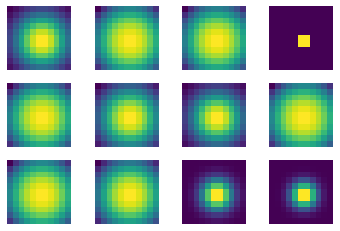

In [ ]:
l = GaussianLayer(filters=4, kernel_size=11)
l.build((None, 32, 32, 3))
l.show_filters()

## Gabor Layer

> Taking what we learnt implementing the `GaussianLayer`, implementing a Gabor layer won't be much different.

In [ ]:
#| export

class GaborLayer(FunctionalLayer):
    """Functional layer with gabor kernels."""

    def __init__(self,
                 **kwargs,
                 ) -> None:
        super(GaborLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(GaborLayer, self).build(input_shape)
        self.fs = tf.Variable(self.kernel_size[0], trainable=False, name="fs", dtype=tf.float32)
        self.freq = tf.Variable(tf.random.uniform(shape=(self.kernels_depth*self.filters,), minval=0, maxval=self.fs/2),
                                trainable=True,
                                name="freq")
        self.logsigmax = tf.Variable(tf.random.uniform(shape=(self.kernels_depth*self.filters,), minval=0, maxval=tf.math.log(2/self.freq)),
                                  trainable=True,
                                  name="sigmax")
        self.logsigmay = tf.Variable(tf.random.uniform(shape=(self.kernels_depth*self.filters,), minval=0, maxval=tf.math.log(2/self.freq)),
                                  trainable=True,
                                  name="sigmay")

        self.theta = tf.Variable(tf.random.uniform(shape=(self.kernels_depth*self.filters,), minval=0, maxval=self.kernel_size[0]),
                                 trainable=True,
                                 name="theta")
        self.sigma_theta = tf.Variable(tf.random.uniform(shape=(self.kernels_depth*self.filters,), minval=0, maxval=self.kernel_size[0]),
                                       trainable=True,
                                       name="sigma_theta")
        self.rot_theta = tf.Variable(tf.random.uniform(shape=(self.kernels_depth*self.filters,), minval=0, maxval=self.kernel_size[0]),
                                     trainable=True,
                                     name="rot_theta")
        self.A = tf.Variable(tf.ones(shape=(self.kernels_depth*self.filters,)), trainable=True, name="A", dtype=tf.float32)
        self.xmean = tf.Variable(0.5, trainable=False, name="xmean", dtype=tf.float32)
        self.ymean = tf.Variable(0.5, trainable=False, name="ymean", dtype=tf.float32)
    
    @property
    def sigmax(self):
        return tf.math.exp(self.logsigmax)

    @property
    def sigmay(self):
        return tf.math.exp(self.logsigmay)

    @tf.function
    def generate_kernel(self):
        """Generates a gabor kernel based on the parameter sigma."""
        gabors = tf.TensorArray(dtype=tf.float32, size=self.logsigmax.shape[0])
        x, y = self.generate_dominion()
        for n in tf.range(start=0, limit=self.logsigmax.shape[0], delta=1, dtype=tf.int32):
            gabor = self.gabor(x, y, 
                               self.xmean, self.ymean, 
                               tf.gather(self.sigmax, n), tf.gather(self.sigmay, n), 
                               tf.gather(self.freq, n),
                               tf.gather(self.theta, n), tf.gather(self.sigma_theta, n), tf.gather(self.rot_theta, n),
                               A=tf.gather(self.A, n))
            gabors = gabors.write(n, gabor)
        gabors = gabors.stack()
        gabors = rearrange(gabors, "(Cin_groups Cout) Kx Ky -> Kx Ky Cin_groups Cout", Cin_groups=self.kernels_depth)
        return gabors

    @staticmethod
    @tf.function
    def gabor(x, # X coordinate.
              y, # Y coordinate
              xmean, # X mean.
              ymean, # Y mean.
              sigmax, # sigma^2 on the X direction.
              sigmay, # sigma^2 on the Y direction.
              freq, # Frequency of the sinusoid.
              theta, # Orientation of the sinusoid.
              sigma_theta, # Orientation of the ??.
              rot_theta, # Rotation of the domain.
              A=1, # Amplitude factor.
              normalize_prob=True, # Wether to normalize the integral to 1 or not.
              ) -> float: # Returns the value for the point (x,y)
        x = tf.cos(rot_theta) * (x - xmean) - tf.sin(rot_theta) * (y - ymean)
        y = tf.sin(rot_theta) * (x - xmean) + tf.cos(rot_theta) * (y - ymean)

        sigma_vector = tf.convert_to_tensor([sigmax, sigmax])
        cov_matrix = tf.linalg.diag(sigma_vector)
        det_cov_matrix = tf.linalg.det(cov_matrix)
        A_norm = tf.convert_to_tensor((1/(2*np.pi*tf.sqrt(det_cov_matrix)))) if normalize_prob else 1

        rotation_matrix = tf.convert_to_tensor([[tf.cos(sigma_theta), -tf.sin(sigma_theta)],
                                                [tf.sin(sigma_theta), tf.cos(sigma_theta)]])
        rotated_covariance = rotation_matrix @ tf.linalg.inv(cov_matrix) @ tf.transpose(rotation_matrix)


        x_r_1 = rotated_covariance[0,0] * x + rotated_covariance[0,1] * y
        y_r_1 = rotated_covariance[1,0] * x + rotated_covariance[1,1] * y

        distance = x * x_r_1 + y * y_r_1

        gabor = A_norm * tf.exp(-distance/2) * tf.cos(2*np.pi*freq*(x*tf.cos(theta)+y*tf.sin(theta)))

        return A*gabor

    @tf.function
    def generate_dominion(self,
                          ): # Returns two tensors, X and Y, to be passed into `gabor`.
        """Generates the 2D dominion over which we want to calculate the gabor."""
        # range_x = tf.range(start=0, limit=self.kernel_size[0], delta=1, dtype=tf.float32)
        # range_y = tf.range(start=0, limit=self.kernel_size[1], delta=1, dtype=tf.float32)
        range_x = tf.linspace(start=0.0, stop=self.kernel_size[0]/self.fs, num=self.kernel_size[0])
        range_y = tf.linspace(start=0.0, stop=self.kernel_size[1]/self.fs, num=self.kernel_size[1])
        return tf.meshgrid(range_x, range_y)        

We see that it behaves exactly the same as `GaussianLayer` but with a different parametric form for the convolution kernels:

In [ ]:
l = GaborLayer(filters=3, kernel_size=11, groups=1, use_bias=False)
l.build((None, 32, 32, 3))
assert l.bias is None

In [ ]:
l = GaborLayer(filters=3, kernel_size=11, groups=3)
l.build((None, 32, 32, 3))
assert l.kernel.shape == tf.TensorShape((11,11,1,3))

2022-11-30 17:06:55.025294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-11-30 17:06:56.925208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


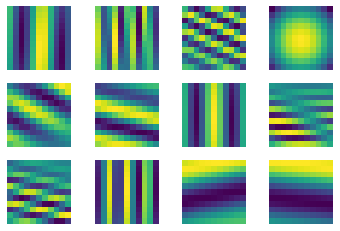

In [ ]:
l = GaborLayer(filters=4, kernel_size=11)
l.build((None, 32, 32, 3))
l.show_filters()